In [2]:
import collections
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage import exposure
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import cv2
fontprops = fm.FontProperties(size=34)
from sklearn.neighbors import NearestNeighbors
from skimage import color, measure, filters
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import skimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import filters
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import gaussian
from skimage.filters.rank import median
from skimage.morphology import disk, ball
from collections import defaultdict
from skimage import img_as_ubyte

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [5]:
from config import *
import my_io as io

In [6]:
data_ROI = data_dir / 'ROI_new'
datasets = ['ROI002']

# Analysis

In [7]:
marker_list = [['E-cadherin','Pankeratin'], ['CD68','HLADR'] , ['CD163', 'CD206'], ['CD8'], ['COL1', 'SMA']]
labels = ['ECA+PanK', 'CD68+HLADR', 'CD163+CD206', 'CD8', 'Col1+SMA']

In [8]:
DEFAULT_CHANNELS = (1, 2, 3, 4, 5)

RGB_MAP = {
    1: {
        'rgb': np.array([255, 0, 255]),
        'range': [0,255]
    },
    2: {
        'rgb': np.array([0,255,0]),
        'range': [0,255]
    },
    3: {
        'rgb': np.array([255,0,0]),
        'range': [0,255]
    },
    4: {
        'rgb': np.array([0,255,255]),
        'range': [0,255]
    },
    5: {
        'rgb': np.array([255, 204, 51]),
        'range': [0,255]
    }
}

def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1,dim2,_ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel-1] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(dim1,dim2, 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im


def one_channel(t, channel, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    x = (t[:, :, 0] / vmax) / (
        (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
    ) + rgb_map[channel]["range"][0] / 255
    x = np.where(x > 1.0, 1.0, x)
    x_rgb = np.array(
        np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
    )
    colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

### Morphology

from skimage.morphology import square, disk
from skimage import morphology 

def get_binary(image):
    blur = cv2.GaussianBlur(image, (9,9), 5)
    th = filters.threshold_otsu(blur)
    binary = blur >= th
    binary = morphology.remove_small_objects(binary, 500)
    binary = morphology.dilation(binary, square(5))
    binary = morphology.closing(binary, disk(5))
    binary = morphology.remove_small_holes(binary, 1000)
    return blur, binary

def myround(x, base=5):
    return base * round(x/base)

def read_img(ROI: str, data_ROI):
    """Read all image from one ROI"""
    dir_ = data_ROI / ROI

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    img_name = [
        name
        for name in sorted(filenames)
        if "tiff" in name and 'contaminant' not in name
    ]
    markers = [name.split("_")[-1].split(".")[0] for name in img_name]
    imgs = np.stack(
        [skimage.io.imread(os.path.join(dirpath, name), True) for name in img_name], axis=0
    )
    return imgs, markers


C:\Users\thu71\AppData\Local\Temp/ipykernel_79768/915561542.py:72: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(data_figure / 'border' / f'{dataset}.png', bbox_inches='tight')
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


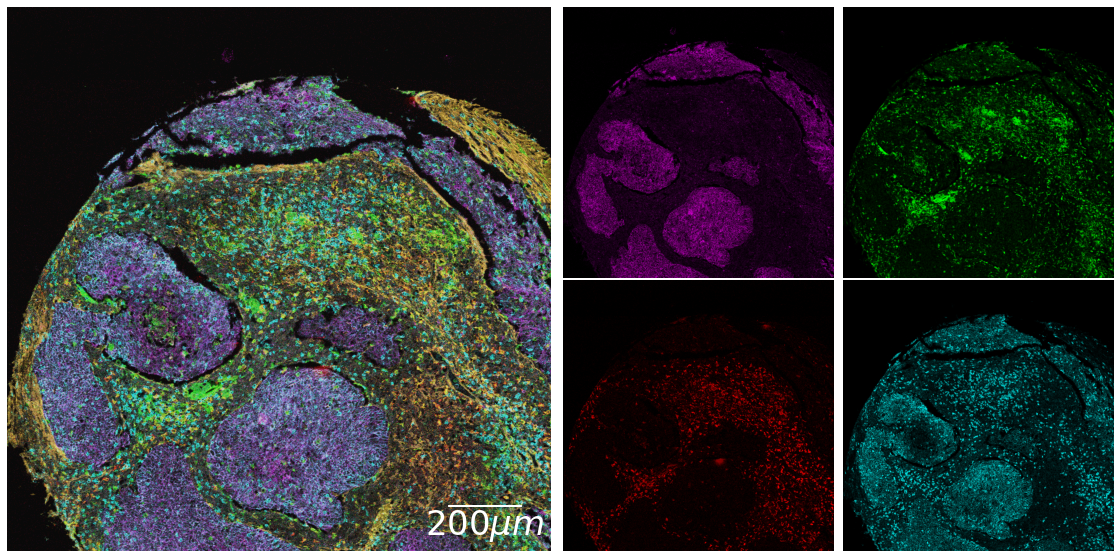

In [9]:
rgb = np.array([item['rgb'] for item in RGB_MAP.values()])
mycmap = ListedColormap(rgb/255)
masks = {}

for dataset in datasets:
    imgs, markers = read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    min_shape = min(imgs[0].shape[0], imgs[0].shape[1])
    min_shape = myround(min_shape, base=25)

    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            p2, p98 = np.percentile(img, (2, 98))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            img = img_as_ubyte(img)
            temp.append(img[:min_shape, :min_shape])
        # if 'CD68' in markers:
        #     img = np.array(np.mean(temp[1:], axis=(0)))
        #     img = np.where(temp[0]>0, img, 0)
        # else:
        #     img = np.array(np.mean(temp, axis=(0)))
        img = np.array(np.mean(temp, axis=(0)))
        imgs_list.append(img)

    data = np.stack(imgs_list, axis=2)

    # Show combined for last
    img_rgb = convert_to_rgb(data, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP)

    # Grayscale backgroun image
    avg_img = np.array(np.mean(imgs, axis=(0)))[:min_shape, :min_shape]
    
    # Plot multiplex image
    fig = plt.figure(constrained_layout=True, figsize=(20,10))
    gs = plt.GridSpec(2, 4, hspace=0.01, wspace=0.01)
    ax = fig.add_subplot(gs[:2, :2])
    ax.axis('off')
    ax.imshow(avg_img, cmap = plt.get_cmap('gray'), alpha = 0.8)
    ax.imshow(img_rgb, alpha=0.8)
#     patches =[mpatches.Patch(color=RGB_MAP[i]['rgb']/255.0,label=labels[i-1]) for i in DEFAULT_CHANNELS]
#     ax.legend(handles=patches, bbox_to_anchor=(0,0), loc='lower right', borderaxespad=0., fontsize=10)
    # Add scale bar
    scalebar = AnchoredSizeBar(ax.transData,
                           200, r'$200  \mu m$', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=3,
                           fontproperties=fontprops)

    ax.add_artist(scalebar)
    
    ax1 = fig.add_subplot(gs[0,2])
    ax1.imshow(one_channel(data[:,:,0][:,:,np.newaxis], 1))
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0,3])
    ax2.imshow(one_channel(data[:,:,1][:,:,np.newaxis], 2))
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[1,2])
    ax3.imshow(one_channel(data[:,:,2][:,:,np.newaxis], 3))
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[1,3])
    ax4.imshow(one_channel(data[:,:,3][:,:,np.newaxis], 4))
    ax4.axis('off')
    
    fig.savefig(data_figure / 'border' / f'{dataset}.png', bbox_inches='tight')
        
plt.show()

# Cell neighborhood analysis

In [10]:
import networkx as nx

def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_ROI 

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'Cell Mask' in name and ROI in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def get_cell_expression_level_mean(imgs_list, labels, cell_mask):
    # Multiple each cell region by mean intensity 
    df_list = []
    for idx, img in enumerate(imgs_list):
        exp_prop = pd.DataFrame(measure.regionprops_table(cell_mask, img, properties=['label','mean_intensity'])).set_index('label')

        df = exp_prop.rename(columns = {'mean_intensity': labels[idx]}, errors = 'raise')
        df_list.append(df)
    df_exp = pd.concat(df_list, axis=1)
    return df_exp

def get_distances(cell_mask, r=30):
    # NN classifier
    neigh = NearestNeighbors(radius=r)
    
    # Get centroid of cellmask
    prop = measure.regionprops_table(cell_mask, properties=['label',"centroid"])
    X = np.column_stack((prop["centroid-0"], prop["centroid-1"]))
    
    # fit the k-NN classifier
    neigh.fit(X)
    distances, neighbors = neigh.radius_neighbors(X, return_distance=True, sort_results=True)
    graph = neigh.radius_neighbors_graph(X, mode='distance').toarray()
    return distances, neighbors, prop['label'], graph, X

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],"b-", color='red', alpha=1, lw=1, zorder=0)

def plot_nn(X, graph, node_colors, ax):
    G = nx.from_numpy_array(graph)
    pos = dict(zip(np.arange(len(X)), X[:,[1,0]]))
    nx.draw(G, pos, node_size=3, node_color=node_colors, edge_color='sandybrown', linewidths=2, ax=ax)
    
def get_cell_color(df, labels, rgb):

    label2num = dict(zip(labels, [i for i in range(len(labels))]))
    num2color = dict([(i, rgb[i]/255) for i in range(len(labels)+1)])
    
    cell_max_marker = df.idxmax(axis=1)
    cell_max_marker = cell_max_marker.apply(label2num.get)
    
    index_low = (df < 0).all(axis=1)
    cell_max_marker[index_low] = 4
    cell_max_color = cell_max_marker.apply(num2color.get)
    
    return cell_max_marker.to_dict(), cell_max_color.values

def replace_with_dict(ar, dic):
    dic[0] = np.nan
    
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

def myround(x, base=5):
    return base * round(x/base)

In [11]:
from collections import defaultdict
from numpy.lib.stride_tricks import as_strided

def get_nei_info(cell_labels, neighbors, node_class, distances):
    node_nei_info = defaultdict(dict)
    for idx, node in enumerate(cell_labels):
        neighbor = neighbors[idx][1:]
        nei_class = np.array([node_class[cell_labels[n]] for n in neighbor])
        nei_distance = distances[idx][1:]   # First distance always correspond to 0 for item itself

        unique, counts = np.unique(nei_class, return_counts=True)
        for idx, c in enumerate(unique):
            node_nei_info[node][c] = {
                'count': counts[idx], 
                'avg_distance': np.mean(nei_distance[np.where(nei_class == c)])
            }
    return node_nei_info
                             
def get_node_patch(X, node_class, n):
    nodes = node_class.keys()
    patches = X//n
    return dict(zip(nodes, patches))

def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(r*b0, c*b1)                      # create new 2D array

def patch_count(c, node_class, node_patch, n, shape):
    matching_node = [k for k, v in node_class.items() if v == c]
    patch_matrix = np.zeros(tuple(d//n for d in shape))
    for node in matching_node:
        i, j = node_patch[node]
        i = int(i)
        j = int(j)
        patch_matrix[i][j] += 1
    patch_matrix = patch_matrix
    return patch_matrix

def patch_count_neighbor(c1, c2, neighbor_class, node_class, node_patch, n, shape):
    patch_matrix = np.zeros(tuple(d//n for d in shape))
    for node, neighbors in neighbor_class.items():
        if neighbors.get(c2) and node_class[node] == c1:
            i, j = node_patch[node]
            i = int(i)
            j = int(j)
            patch_matrix[i][j] += neighbors.get(c2)['count']
    patch_matrix = patch_matrix
    return patch_matrix

def count_neighbor(c1, c2, neighbor_class, node_class):
    count = 0
    for node, neighbors in neighbor_class.items():
        if neighbors.get(c2) and node_class[node] == c1:
            count += neighbors.get(c2)['count']
    return count

def plot_count_patch(node_class, node_patch, n, shape, path=None):
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(patch_count(c, node_class, node_patch, n, shape))

    fig, axs = plt.subplots(2,2, figsize = (12,10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix),
                         vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis('off')
        im = ax.imshow(patch_matrix[c], cmap = 'RdYlBu_r', norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label('Count')
    if path:
         fig.savefig(path, bbox_inches='tight')
    
def plot_interaction_patch(init_c, node_class, node_patch, n, shape, cmap, path=None):
    init_c = 0
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(patch_count_neighbor(init_c, c, neighbor_class, node_patch, n, shape))

    fig, axs = plt.subplots(2,2, figsize = (12,10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix),
                         vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis('off')
        im = ax.imshow(patch_matrix[c], cmap = cmap, norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label('Count')
    if path:
         fig.savefig(path, bbox_inches='tight')

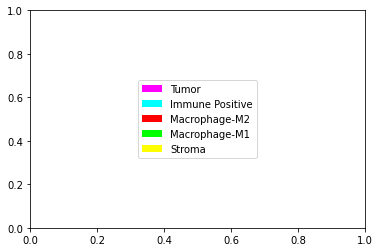

In [12]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=[1,0,1], 
                         label='Tumor'),
                   Patch(facecolor=[0, 1, 1], 
                         label='Immune Positive'),
                   Patch(facecolor=[1, 0, 0], 
                         label='Macrophage-M2'),
                   Patch(facecolor=[0, 1, 0], 
                         label='Macrophage-M1'),
                   Patch(facecolor=[1, 1, 0], 
                         label='Stroma')
                  ]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

plt.show()

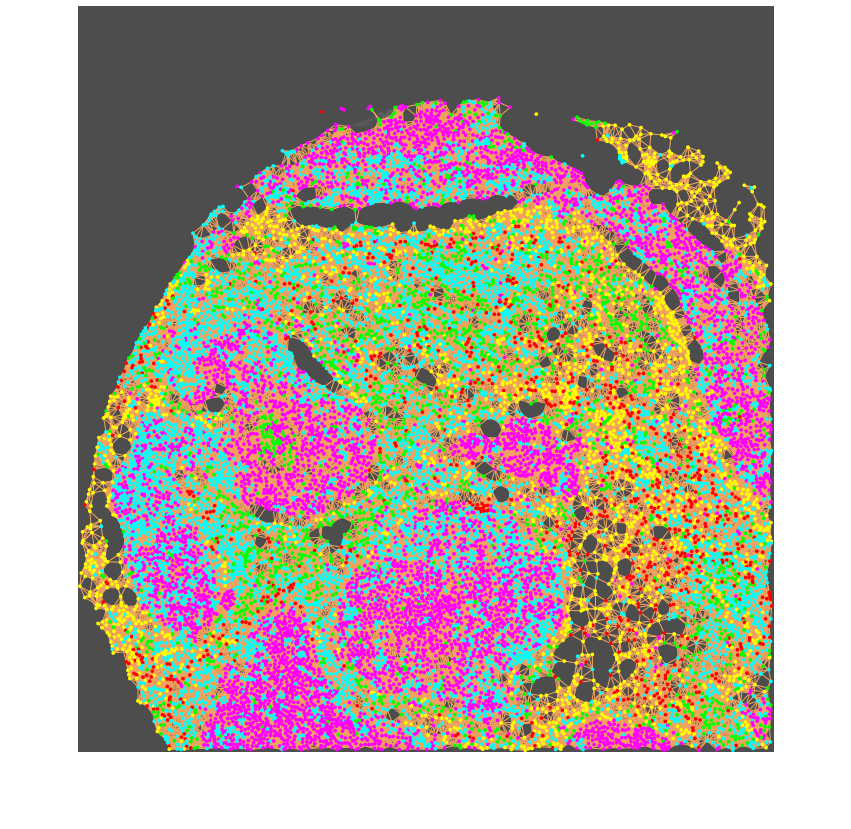

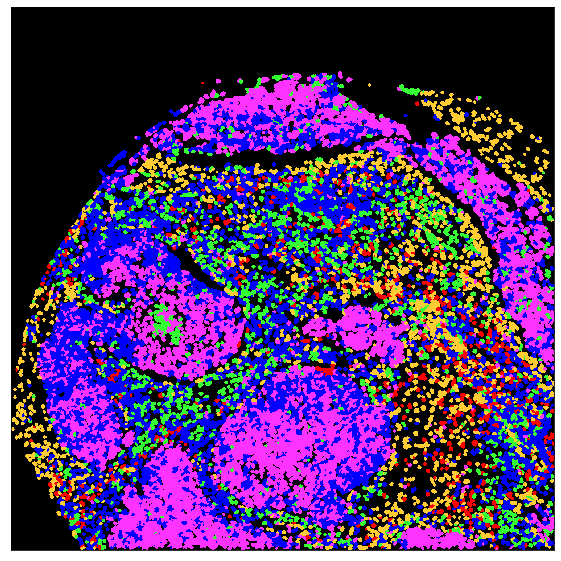

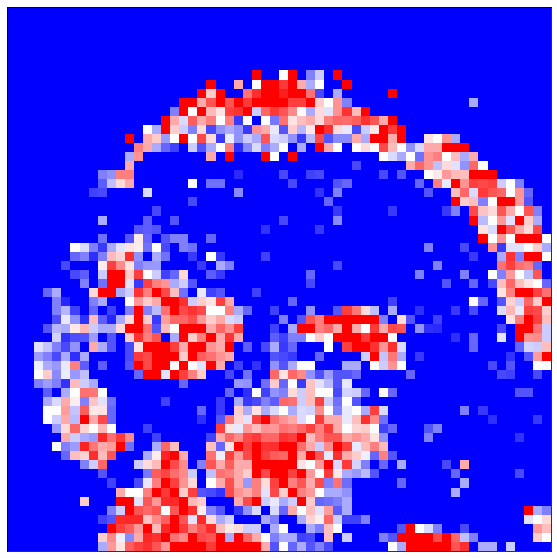

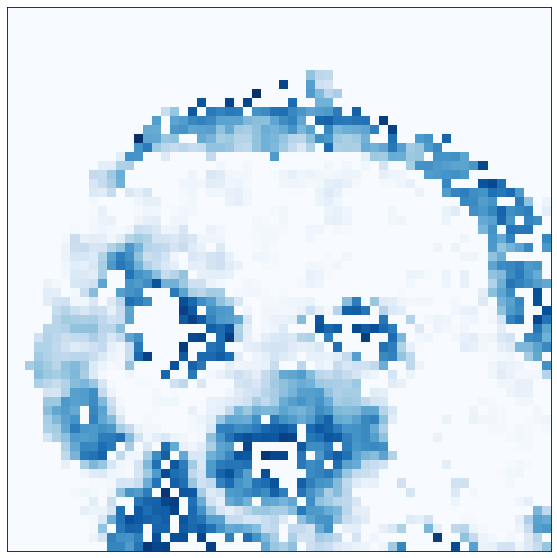

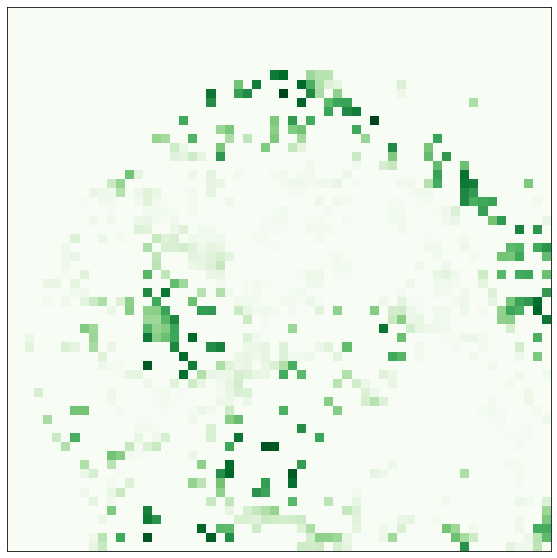

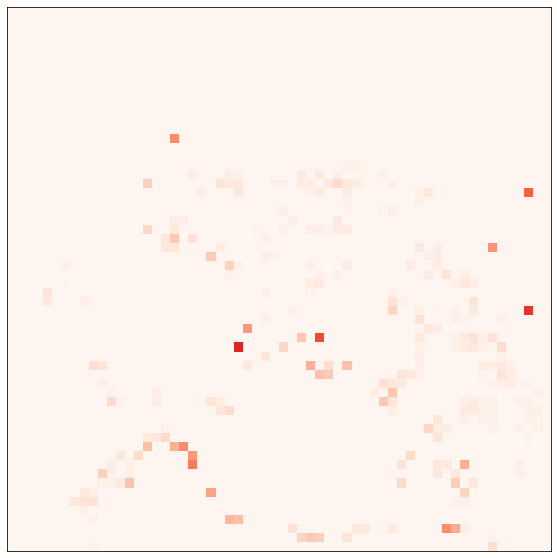

In [115]:
marker_list = [['E-cadherin','Pankeratin'], ['CD68','HLADR'] , ['CD163', 'CD206'], ['CD8'], ['COL1', 'SMA']]
labels = ['ECA+PanK', 'CD68+HLADR', 'CD163+CD206', 'CD8', 'Col1+SMA']

rgb = np.array([[255,0,255], [0,255,0], [255,0,0], [0,255,255], [255,255,0], [160,160,160]])
mycmap = ListedColormap(rgb/255)
rgb2 = np.array([[255,51,255], [51,255,51], [255,0,0], [0,0,255], [255,204,51], [160,160,160]])
mycmap2 = ListedColormap(rgb2/255)
scores = defaultdict(list)
scores_count = defaultdict(list)
show=True
n = 25

for dataset in datasets:

    # Read image and cell_mask
    imgs, markers = read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    cell_mask = read_cell_mask(dataset)
    min_shape = min(cell_mask.shape[0], cell_mask.shape[1])
    min_shape = myround(min_shape, base=n)
    cell_mask = cell_mask[:min_shape, :min_shape]
    
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            p2, p98 = np.percentile(img, (2, 98))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[:min_shape, :min_shape])
        imgs_list.append(np.array(np.mean(temp, axis=(0))))

    # Grayscale backgroun image
    avg_img = np.array(np.mean(imgs, axis=(0)))[:min_shape, :min_shape]

    # Get cell neighbors analysis
    distances, neighbors, cell_labels, graph, X = get_distances(cell_mask)
    df = get_cell_expression_level_mean(imgs_list, labels, cell_mask)
    node_class, node_colors = get_cell_color(df, labels, rgb)
    
    neighbor_class = get_nei_info(cell_labels, neighbors, node_class, distances)
    node_patch = get_node_patch(X, node_class, n)
    
    #Plot proximity map
    fig, ax = plt.subplots(figsize=(15,15))
    ax.axis('off')
    top, right = avg_img.shape
    ax.imshow(avg_img, cmap='gray', alpha=0.7, aspect='auto', extent=[0,right,0,top], origin='lower')
    plot_nn(X, graph, node_colors, ax)
    ax.invert_yaxis()
    scalebar = AnchoredSizeBar(ax.transData,
                           200, r'$200  \mu m$', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=3,
                           fontproperties=fontprops)

    ax.add_artist(scalebar)
    fig.savefig(data_figure / 'border' / f'cell_graph_{dataset}.png', bbox_inches='tight')
    
    #Plot cell mask
    img = replace_with_dict(cell_mask , node_class)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img, cmap=mycmap2, interpolation='None', vmin=0, vmax=5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('black')
    fig.savefig(data_figure / 'border' / f'cell_mask_{dataset}.png', bbox_inches='tight')
    
    
    # Get Tumor and Stroma island 
    
    tumor = patch_count(0, node_class, node_patch, n, avg_img.shape)
    inegatif_m2 = patch_count(1, node_class, node_patch, n, avg_img.shape)
    inegatif_m1 = patch_count(2, node_class, node_patch, n, avg_img.shape)
    ipositif = patch_count(3, node_class, node_patch, n, avg_img.shape)
    stroma = patch_count(4, node_class, node_patch, n, avg_img.shape)
    
    total = [patch_count(i, node_class, node_patch, n, avg_img.shape)  for i in range(5)]
    total = np.sum(total, axis=(0))
    P_tumor = np.divide(tumor, total, out=np.zeros_like(total), where=total!=0)
    P_ip = np.divide(ipositif, total, out=np.zeros_like(total), where=total!=0)
    P_in_m1 = np.divide(inegatif_m1, total, out=np.zeros_like(total), where=total!=0)
    P_in_m2 = np.divide(inegatif_m2, total, out=np.zeros_like(total), where=total!=0)
    P_stroma = np.divide(stroma, total, out=np.zeros_like(total), where=total!=0)

    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(P_tumor, vmin=0, vmax=1, cmap='bwr')
        ax.tick_params(axis=u'both', which=u'both',length=0, labelbottom=False, labelleft=False)
        fig.savefig(data_figure / 'border' / f'tumor_stroma_{dataset}.png', bbox_inches='tight')
        plt.show()

    # IP to tumor
    ip_t_int = patch_count_neighbor(3, 0, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_s_int = patch_count_neighbor(3, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_ip_int = patch_count_neighbor(3, 3, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_int_total = [patch_count_neighbor(3, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    ip_int_total = np.sum(ip_int_total, axis=(0))
    P_ip_t = np.divide(ip_t_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)
    P_ip_s = np.divide(ip_s_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)
    P_ip_ip = np.divide(ip_ip_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)

    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(P_ip_t, vmin=0, vmax=1, cmap='Blues')
        ax.tick_params(axis=u'both', which=u'both',length=0, labelbottom=False, labelleft=False)
        
        fig.savefig(data_figure / 'border' / f'int_imp_{dataset}.png', bbox_inches='tight')
        plt.show()
    
    # IN to tumor
    in_t_int = patch_count_neighbor(1, 0, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_ip_int = patch_count_neighbor(1, 3, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_s_int = patch_count_neighbor(1, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_int_total = [patch_count_neighbor(1, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    in_int_total = np.sum(in_int_total, axis=(0))
    P_in_t = np.divide(in_t_int, in_int_total, out=np.zeros_like(in_int_total), where=in_int_total!=0)
    P_in_s = np.divide(in_s_int, in_int_total, out=np.zeros_like(in_int_total), where=in_int_total!=0)
    P_in_in = np.divide(in_ip_int, in_int_total, out=np.zeros_like(in_int_total), where=in_int_total!=0)

    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(P_in_t, vmin=0, vmax=1, cmap='Greens')
        ax.tick_params(axis=u'both', which=u'both',length=0, labelbottom=False, labelleft=False)
        
        fig.savefig(data_figure / 'border' / f'int_imn_{dataset}.png', bbox_inches='tight')
        plt.show()
        
     # IN to tumor
    in_t_int_2 = patch_count_neighbor(2, 0, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_ip_int_2 = patch_count_neighbor(2, 3, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_s_int_2 = patch_count_neighbor(2, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    in_int_total_2 = [patch_count_neighbor(2, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    in_int_total_2 = np.sum(in_int_total_2, axis=(0))
    P_in_t_2 = np.divide(in_t_int_2, in_int_total_2, out=np.zeros_like(in_int_total), where=in_int_total_2!=0)
    P_in_s_2 = np.divide(in_s_int_2, in_int_total_2, out=np.zeros_like(in_int_total), where=in_int_total_2!=0)
    P_in_in_2 = np.divide(in_ip_int_2, in_int_total_2, out=np.zeros_like(in_int_total), where=in_int_total_2!=0)

    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(P_in_t_2, vmin=0, vmax=1, cmap='Reds')
        ax.tick_params(axis=u'both', which=u'both',length=0, labelbottom=False, labelleft=False)
        
        fig.savefig(data_figure / 'border' / f'int_imn_{dataset}.png', bbox_inches='tight')
        plt.show()
        
    scores['Tumor'].append(round(np.mean(P_tumor),4))
    scores['Stroma'].append(round(np.mean(P_stroma),4))
    scores['IP'].append(round(np.mean(P_ip),4))
    scores['IN'].append(round(np.mean(P_in),4))
    scores['IP_T'].append(round(np.mean(P_ip_t),4))
    scores['IP_IP'].append(round(np.mean(P_ip_ip),4))
    scores['IP_S'].append(round(np.mean(P_ip_s),4))
    scores['IN_T'].append(round(np.mean(P_in_t),4))
    scores['IN_IN'].append(round(np.mean(P_in_in),4))
    scores['IN_S'].append(round(np.mean(P_in_s),4))


    scores_count['Tumor_Tumor'].append(count_neighbor(0, 0, neighbor_class, node_class))
    scores_count['Tumor_IN'].append(count_neighbor(0, 1, neighbor_class, node_class))
    scores_count['Tumor_IP'].append(count_neighbor(0, 2, neighbor_class, node_class))
    scores_count['Tumor_Stroma'].append(count_neighbor(0, 3, neighbor_class, node_class))
    scores_count['IN-IN'].append(count_neighbor(1, 1, neighbor_class, node_class))
    scores_count['IN-IP'].append(count_neighbor(1, 2, neighbor_class, node_class))
    scores_count['IN-Stroma'].append(count_neighbor(1, 3, neighbor_class, node_class))
    scores_count['IP-IP'].append(count_neighbor(2, 2, neighbor_class, node_class))
    scores_count['IP-Stroma'].append(count_neighbor(2, 3, neighbor_class, node_class))
    scores_count['Stroma-Stroma'].append(count_neighbor(3, 3, neighbor_class, node_class))


plt.show()